In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import mne 
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.signal import periodogram
from pymultifracs.viz import plot_psd
from pymultifracs import mfa, wavelet_analysis
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from evaluation import summarize_decomposition_results

In [3]:
%matplotlib inline

## 1. Signal extraction

In [7]:
raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")
#raw = mne.io.read_raw_fif("../data/real/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.


## 2. Signal exploration

In [6]:
raw

<Raw | sub-01_ses-01_task-rest_proc-filt_raw.fif, 356 x 82500 (330.0 s), ~539 KiB, data not loaded>

Using matplotlib as 2D backend.


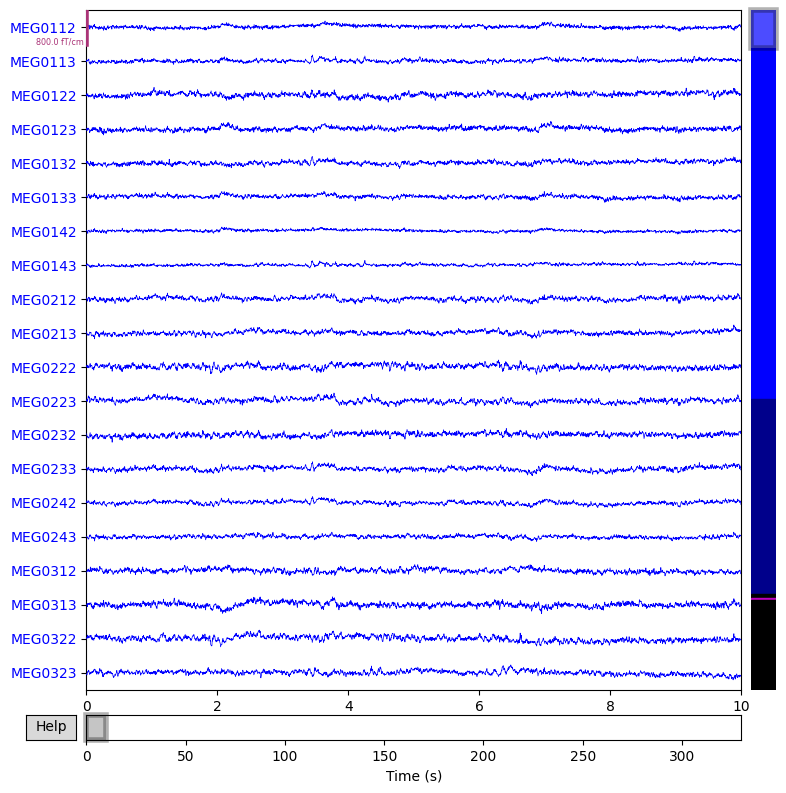

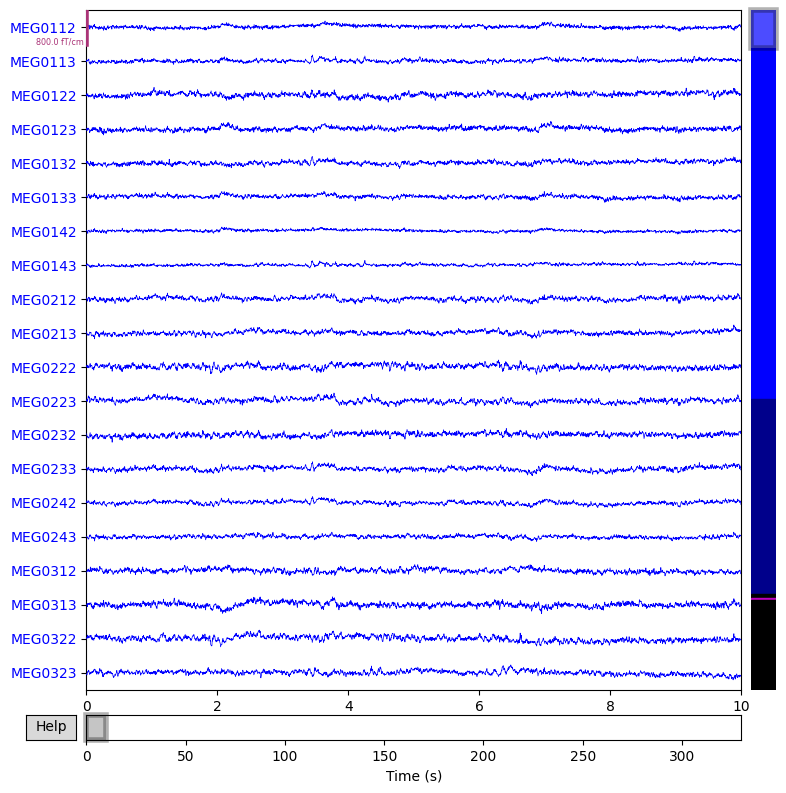

In [6]:
raw.plot()

In [7]:
# Make a copy and pick MEG channels by type
raw_meg = raw.copy().pick('meg')  # Magnetometers and gradiometers

# Apply filtering
#raw_meg_filtered = raw_meg.filter(l_freq=8.0, h_freq=12.0)

In [8]:
data_matrix = raw_meg.get_data()

In [9]:
print(data_matrix.shape)
type(data_matrix)

(306, 82500)


numpy.ndarray

In [10]:
sfreq = raw.info["sfreq"]
sfreq

250.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


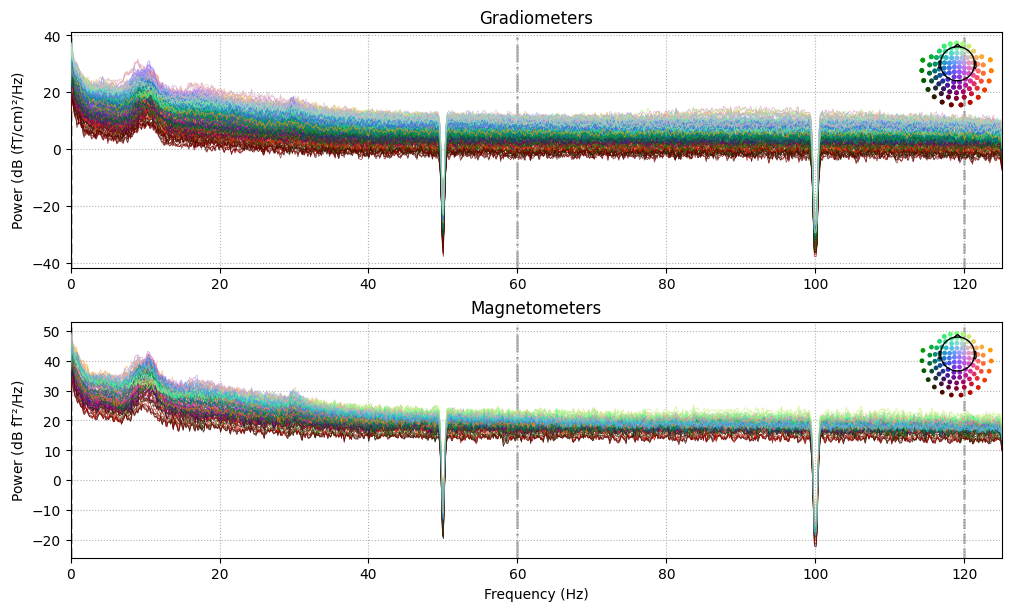

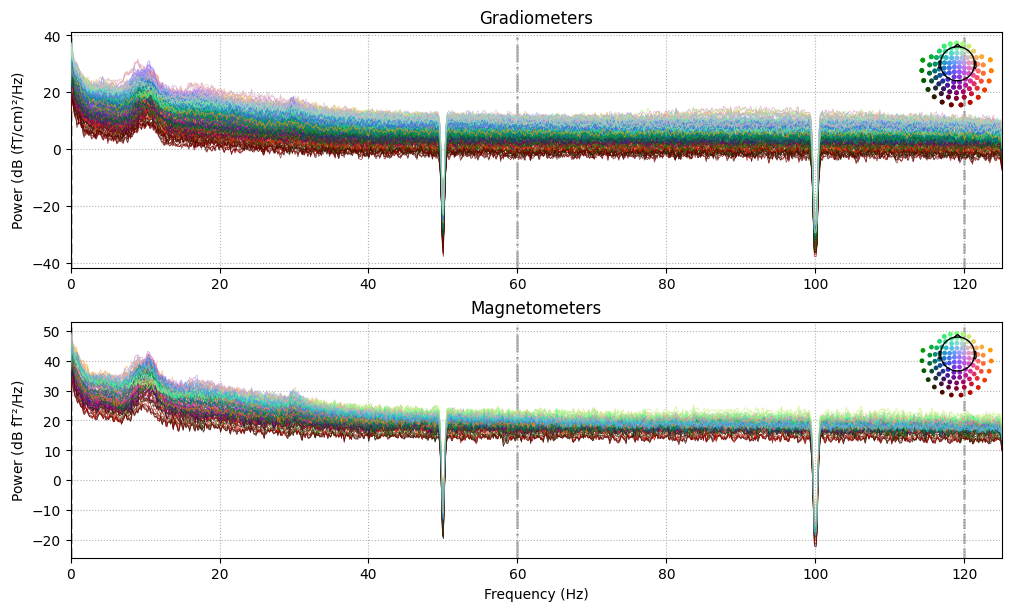

In [11]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


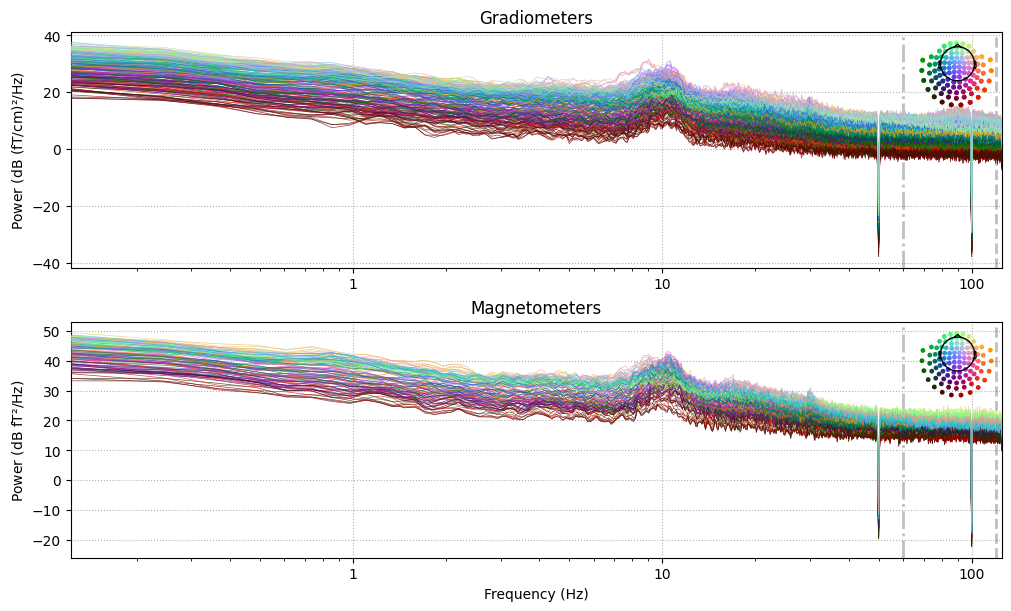

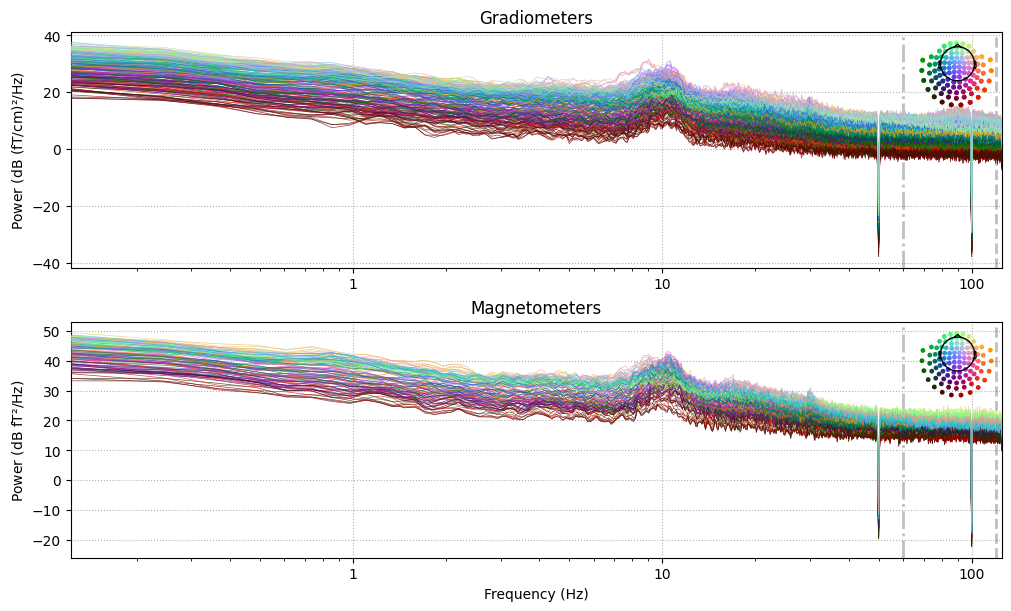

In [12]:
raw.plot_psd(xscale="log")

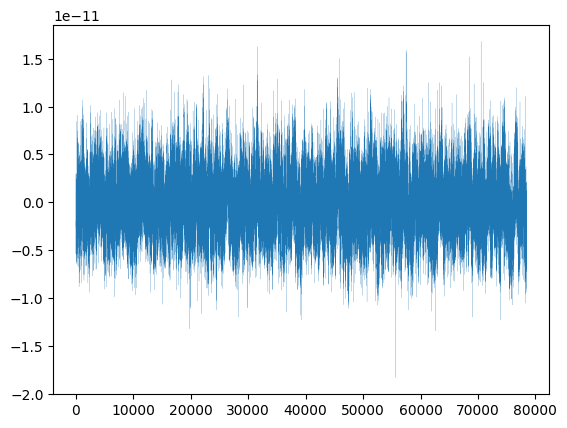

In [13]:
X = data_matrix[2, 2000:-2000]
plt.plot(X, lw=.1)
plt.show()

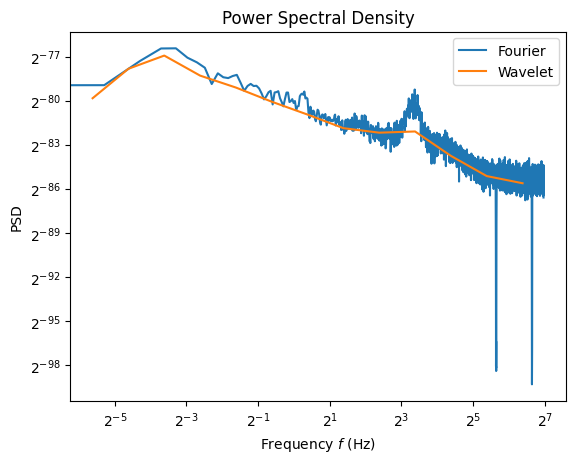

In [14]:
from pymultifracs.viz import plot_psd
plot_psd(X, fs=sfreq)

In [15]:
WT = wavelet_analysis(X, 'db6').integrate(1)

In [16]:
WT.freq2scale(2.0, sfreq)
WT.scale2freq(9, sfreq)

np.float64(0.35511363636363635)

In [17]:
dwt = mfa(WT, [(6, 11)])

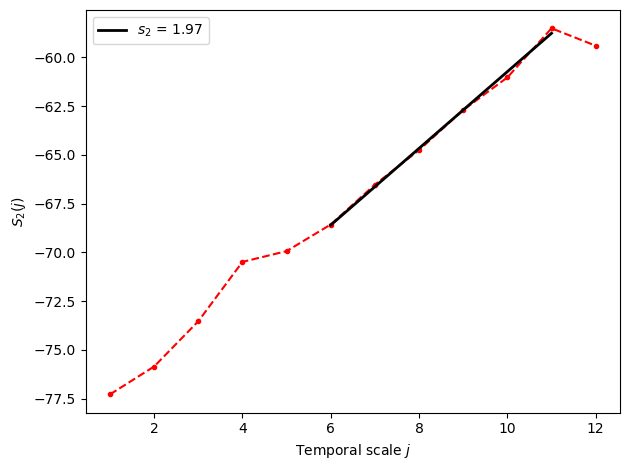

In [18]:
dwt.structure.plot()

In [19]:
H = float(dwt.structure.H.squeeze())

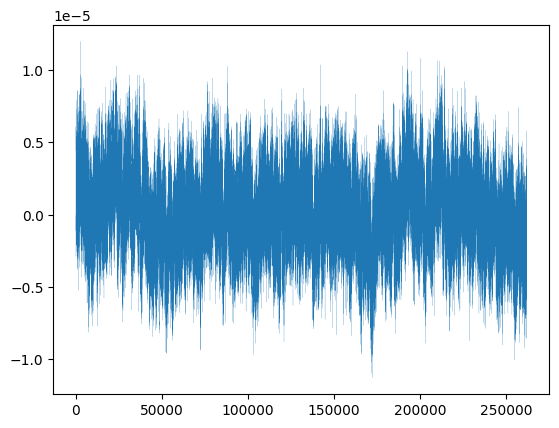

In [20]:
from pymultifracs.simul import fbm
Y = fbm(shape=(2 ** 18), H=H)
plt.plot(np.diff(Y), lw=.1)

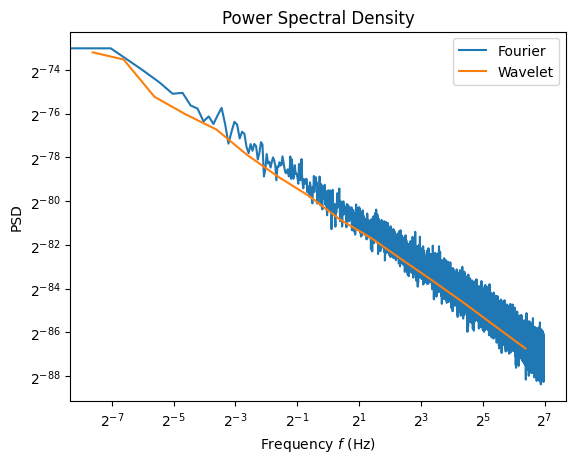

In [21]:
from pymultifracs.viz import plot_psd
plot_psd(np.diff(Y) / np.diff(Y).std() * X.std(), sfreq)


(1.6155871338926322e-27, 1.0587911840678754e-22)

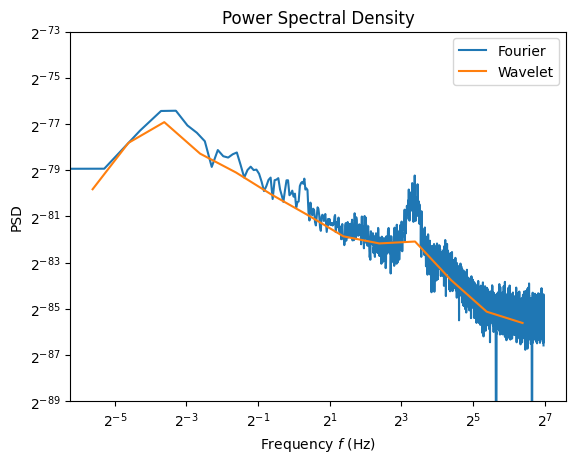

In [22]:
plot_psd(X, sfreq)
plt.ylim(2**-89,2**-73)

## Benchmark 

In [23]:
raw_meg = raw.copy().pick('meg')
selected_channels = ['MEG0111', 'MEG0211', 'MEG0311', 'MEG1511', 'MEG2411']
raw_subset = raw_meg.copy().pick_channels(selected_channels)
data_subset = raw_subset.get_data()  # shape: (5, n_times)
fs = int(raw_subset.info['sfreq'])  # use real sampling freq, not hardcoded

# ========== 2. VMD Parameters ==========
Nmodes_list = [5, 6, 7]
alphas = [200, 1000, 5000, 10000, 100000]
tau = 0.5
tol = 1e-7
init = 0
DC = 1
tolerance = 2 
expected_freqs = None  

# ========== 3. Helper functions (reused) ==========
def spectral_overlap_index(mode1, mode2, fs):
    f1, Pxx1 = periodogram(mode1, fs=fs)
    f2, Pxx2 = periodogram(mode2, fs=fs)
    if not np.allclose(f1, f2):
        raise ValueError("Frequency bins do not match.")
    num = np.sum(np.minimum(Pxx1, Pxx2))
    den = min(np.sum(Pxx1), np.sum(Pxx2))
    return 0.0 if den == 0 else num / den

def compute_soi_matrix(modes, fs):
    K = len(modes)
    soi = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            soi[i, j] = spectral_overlap_index(modes[i], modes[j], fs)
    mean_soi = np.mean(soi[np.triu_indices(K, k=1)])
    return soi, mean_soi

def peak_frequency(mode, fs):
    f, Pxx = periodogram(mode, fs=fs)
    if len(Pxx) == 0:
        return 0
    return f[np.argmax(Pxx)]

def test_vmd_params(signal, fs, Nmodes_list, alphas):
    records = []
    spectra = {}

    for Nm in Nmodes_list:
        for alpha in alphas:
            IMFs, _, _ = VMD(signal, alpha=alpha, tau=tau, K=Nm, DC=DC, init=init, tol=tol)
            reconstructed = np.sum(IMFs, axis=0)
            mae_scaled = mean_absolute_error(signal, reconstructed)

            # MAE in original space (for reporting or interpretation)
            mae = mae_scaled / scaling_factor
            _, mean_soi = compute_soi_matrix(IMFs, fs)
            peak_freqs = [peak_frequency(mode, fs) for mode in IMFs]

            record = {
                'Nmodes': Nm,
                'alpha': alpha,
                'peak_frequencies': ', '.join(f"{pf:.2f}" for pf in peak_freqs),
                'mae': mae,
                'mean_soi': mean_soi
            }
            records.append(record)
            spectra[(Nm, alpha)] = IMFs

    df = pd.DataFrame(records)
    return df, spectra


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [24]:
# ========== 4. Apply to all selected MEG channels ==========
scaling_factor = 1e11
all_results = []
benchmark_results = {}

for i, ch_name in enumerate(selected_channels):
    print(f"\n🔍 Channel: {ch_name}")
    signal = data_subset[i]
    signal_rescaled = signal * scaling_factor

    df, spectra = test_vmd_params(signal_rescaled, fs, Nmodes_list, alphas)
    df['channel'] = ch_name
    all_results.append(df)
    benchmark_results[ch_name] = {'df': df, 'spectra': spectra}

# ========== 5. Save results ==========
df_all_channels = pd.concat(all_results, ignore_index=True)

with open("../results/real/benchmark/vmd_meg_subset_results.pkl", "wb") as f:
    pickle.dump(benchmark_results, f)

df_all_channels.to_csv("../results/real/benchmark/vmd_meg_subset_summary.csv", index=False)



🔍 Channel: MEG0111

🔍 Channel: MEG0211

🔍 Channel: MEG0311

🔍 Channel: MEG1511

🔍 Channel: MEG2411


In [65]:
df_all_channels[df_all_channels["channel"]=="MEG2411"].sort_values(by="mean_soi",ascending=True)

,Nmodes,alpha,peak_frequencies,mae,mean_soi,channel
64,5,100000,"0.07, 60.92, 66.03, 85.83, 105.92",2.382085e-13,0.003513,MEG2411
69,6,100000,"0.07, 59.47, 62.63, 82.92, 102.37, 121.74",2.112368e-13,0.004675,MEG2411
63,5,10000,"0.07, 10.58, 32.07, 44.59, 92.12",1.355804e-13,0.005712,MEG2411
73,7,10000,"0.07, 10.58, 26.65, 35.25, 67.95, 89.55, 106.38",7.874953e-14,0.006739,MEG2411
62,5,5000,"0.07, 10.58, 20.15, 80.26, 94.51",1.168185e-13,0.010778,MEG2411
72,7,5000,"0.07, 10.58, 27.53, 38.09, 75.65, 81.79, 123.82",4.804579e-14,0.011190,MEG2411
67,6,5000,"0.07, 10.58, 32.07, 44.59, 89.55, 98.12",4.671642e-14,0.013698,MEG2411
68,6,10000,"0.07, 6.15, 10.58, 32.07, 51.68, 72.80",1.221018e-13,0.015574,MEG2411
71,7,1000,"0.07, 10.58, 18.76, 37.39, 51.68, 115.33, 75.65",1.446192e-14,0.015802,MEG2411
61,5,1000,"0.07, 10.58, 32.07, 51.68, 123.82",5.156698e-14,0.017433,MEG2411


## 3. Signal decomposition

### Set Parameters:

In [8]:
# Load MEG data
raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")
raw_meg = raw.copy().pick('meg')
data_matrix = raw_meg.get_data()  # (n_channels, n_times)

# Parameters (from your code)
fs = 250  # Sampling frequency
duration = 300.0  # Duration to plot (seconds)
max_points = 1000
methods = ["VMD"]

max_imfs = 6
max_modes = 6
K = 6

#alpha first 200 best + 6 
#alpha 1000 good
# alpha 100000 worst

best_vmd_params = {
    'meg': {'vmd_alpha': 200, 'vmd_tau': 0.5, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 6},
}

output_base = "../results/real/"

n_channels_to_process = 306  # First 10 magnetometers

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.


### Run the Decompositions:

In [272]:
#scale_factor = 1e11

for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]
    #signal_rescaled = signal * scale_factor
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    signal_standardized = (signal - signal_mean) / signal_std
    name = f"meg_channel_{ch_idx}"

    print(f"--- Decomposition for: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    params = best_vmd_params.get('meg', {})

    modes_dict = run_all_decompositions(
        signal_in=signal_standardized,
        methods=methods,
        Fs=fs,
        Nmodes=params.get('Nmodes', 3),
        MaxEmdIMF=max_imfs,
        MaxVmdModes=max_modes,
        vmd_alpha=params.get('vmd_alpha', 1),
        vmd_tau=params.get('vmd_tau', 0),
        vmd_DC=params.get('vmd_DC', 1),
        vmd_init=params.get('vmd_init', 0),
        vmd_tol=params.get('vmd_tol', 1e-1),
        return_modes=True
    )

    # Rescale modes back to original scale
    for method in modes_dict:
        #modes_dict[method] = modes_dict[method] / scale_factor
        modes_dict[method] = modes_dict[method] * signal_std + signal_mean


    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        print(f"Saved modes for {method} of {name}")


--- Decomposition for: meg_channel_0 ---
VMD decomposition done in 4.54 seconds.
Saved modes for VMD of meg_channel_0
--- Decomposition for: meg_channel_1 ---
VMD decomposition done in 4.18 seconds.
Saved modes for VMD of meg_channel_1
--- Decomposition for: meg_channel_2 ---
VMD decomposition done in 3.91 seconds.
Saved modes for VMD of meg_channel_2
--- Decomposition for: meg_channel_3 ---
VMD decomposition done in 4.56 seconds.
Saved modes for VMD of meg_channel_3
--- Decomposition for: meg_channel_4 ---
VMD decomposition done in 5.16 seconds.
Saved modes for VMD of meg_channel_4
--- Decomposition for: meg_channel_5 ---
VMD decomposition done in 5.42 seconds.
Saved modes for VMD of meg_channel_5
--- Decomposition for: meg_channel_6 ---
VMD decomposition done in 5.25 seconds.
Saved modes for VMD of meg_channel_6
--- Decomposition for: meg_channel_7 ---
VMD decomposition done in 6.33 seconds.
Saved modes for VMD of meg_channel_7
--- Decomposition for: meg_channel_8 ---
VMD decompositi

In [46]:
# Once modes saved, run feature extraction on MEG channels:
for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)
    
    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")

        compute_features_from_modes_and_save(modes_path, features_path, fs)
        print(f"Features saved for {method} of {name}")


Features saved to ../results/real/meg_channel_0/VMD/features/meg_channel_0_features.csv
Features saved for VMD of meg_channel_0
Features saved to ../results/real/meg_channel_1/VMD/features/meg_channel_1_features.csv
Features saved for VMD of meg_channel_1
Features saved to ../results/real/meg_channel_2/VMD/features/meg_channel_2_features.csv
Features saved for VMD of meg_channel_2
Features saved to ../results/real/meg_channel_3/VMD/features/meg_channel_3_features.csv
Features saved for VMD of meg_channel_3
Features saved to ../results/real/meg_channel_4/VMD/features/meg_channel_4_features.csv
Features saved for VMD of meg_channel_4
Features saved to ../results/real/meg_channel_5/VMD/features/meg_channel_5_features.csv
Features saved for VMD of meg_channel_5
Features saved to ../results/real/meg_channel_6/VMD/features/meg_channel_6_features.csv
Features saved for VMD of meg_channel_6
Features saved to ../results/real/meg_channel_7/VMD/features/meg_channel_7_features.csv
Features saved f

In [ ]:
# Generate plots for MEG channels:
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=ch_idx,
            output_dir=output_dir,
            duration=duration,
            max_points=max_points,
            spectrum_method='windowed_fft'  # or 'psd' or 'fft'
        )
        print(f"Plots saved for {method} of {name}")

### Analyze the Results:

In [22]:
method = "VMD"

modes_by_channel = []

for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")

    if not os.path.exists(mode_path):
        print(f"❌ Missing modes for channel {ch_idx}")
        continue

    modes = np.load(mode_path)  # (K, T)
    modes_by_channel.append(modes)

n_channels_loaded = len(modes_by_channel)
print(f"✅ Loaded {n_channels_loaded} channels.")

✅ Loaded 306 channels.


In [45]:
# # Create a list of lists: one list per mode
# all_modes = [[] for _ in range(K)]

# # Load and organize modes from all channels
# for ch_idx in range(n_channels_to_process):
#     name = f"meg_channel_{ch_idx}"
#     mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    
#     if not os.path.exists(mode_path):
#         continue

#     modes = np.load(mode_path)  # shape: (K, T)
#     for k in range(K):
#         all_modes[k].append(modes[k])  # Add kth mode for this channel

# # Concatenate each mode across all channels: shape (n_channels * T,)
# all_modes_concat = [np.concatenate(m) for m in all_modes]  # List of 1D arrays

# # Initialize K x K correlation matrix
# cross_mode_corr = np.zeros((K, K))

# for i in range(K):
#     for j in range(K):
#         cross_mode_corr[i, j] = np.corrcoef(all_modes_concat[i], all_modes_concat[j])[0, 1]

# # Plot
# plt.figure(figsize=(6, 5))
# im = plt.imshow(cross_mode_corr, vmin=-1, vmax=1, cmap="coolwarm")
# plt.colorbar(im, label="Correlation")
# plt.title("Correlation Between VMD Modes Across All Channels")
# plt.xlabel("Mode")
# plt.ylabel("Mode")

# # Annotate with values
# for i in range(K):
#     for j in range(K):
#         plt.text(j, i, f"{cross_mode_corr[i, j]:.2f}", ha='center', va='center', color='black')

# plt.tight_layout()
# plt.show()


In [24]:
# --- Band classification ---
def get_band(freq):
    if 1 <= freq < 4:
        return "Delta"
    elif 4 <= freq < 8:
        return "Theta"
    elif 8 <= freq < 13:
        return "Alpha"
    elif 13 <= freq < 30:
        return "Beta"
    elif 30 <= freq < 100:
        return "Gamma"
    elif freq >= 100:
        return "High Gamma"
    else:
        return "NotClassified"
    
# --- Collect peak frequencies ---
peak_freqs = []

for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    
    if not os.path.exists(mode_path):
        print(f"❌ Missing: {name}")
        continue
    
    modes = np.load(mode_path)  # shape (K, T)
    
    for mode_idx in range(K):
        mode = modes[mode_idx]
        f, Pxx = periodogram(mode, fs=fs)
        peak = f[np.argmax(Pxx)]
        band = get_band(peak)
        peak_freqs.append({
            "channel": name,
            "mode": mode_idx ,
            "peak_freq": peak,
            "band": band
        })

# --- Convert to DataFrame ---
df_bands = pd.DataFrame(peak_freqs)


# --- Optional: Save ---
df_bands.to_csv("../results/real/peak_band_summary.csv", index=False)

In [25]:
df_bands.head(5)

,channel,mode,peak_freq,band
0,meg_channel_0,0,0.118182,NotClassified
1,meg_channel_0,1,10.975758,Alpha
2,meg_channel_0,2,29.739394,Beta
3,meg_channel_0,3,55.318182,Gamma
4,meg_channel_0,4,87.963636,Gamma


In [26]:
df_bands["band"].value_counts()

band
Gamma            715
NotClassified    306
Alpha            306
High Gamma       306
Beta             203
Name: count, dtype: int64

In [27]:
band_table = (
     df_bands
    .groupby(["mode", "band"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

display(band_table)


band,Alpha,Beta,Gamma,High Gamma,NotClassified
mode,,,,,
0,0,0,0,0,306
1,306,0,0,0,0
2,0,203,103,0,0
3,0,0,306,0,0
4,0,0,306,0,0
5,0,0,0,306,0


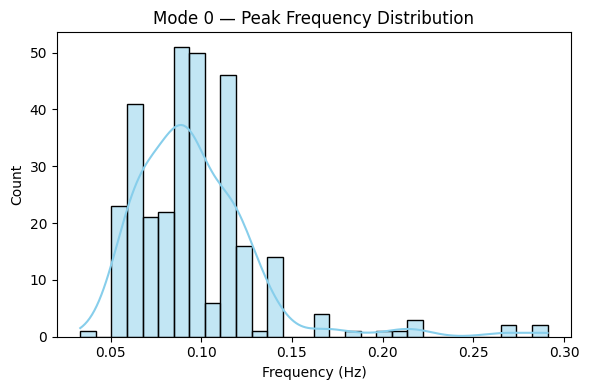

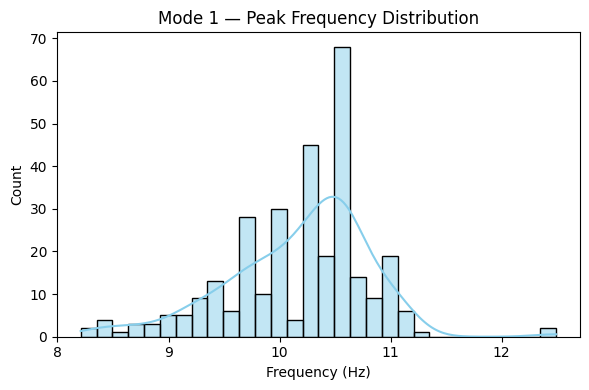

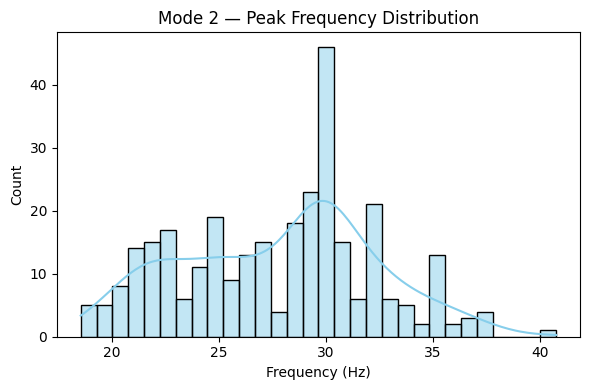

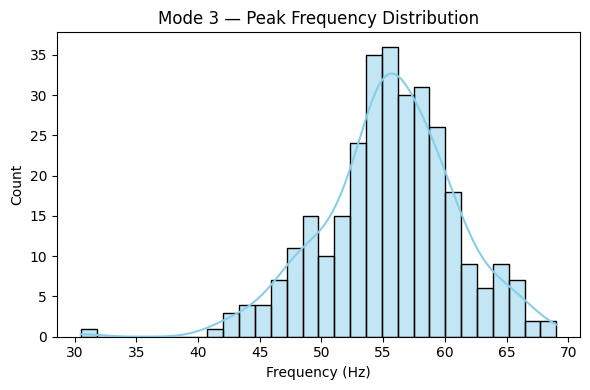

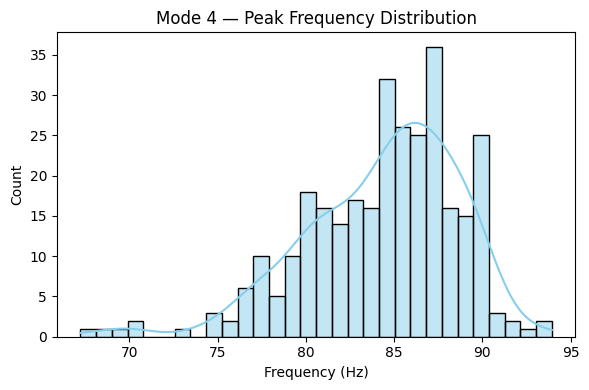

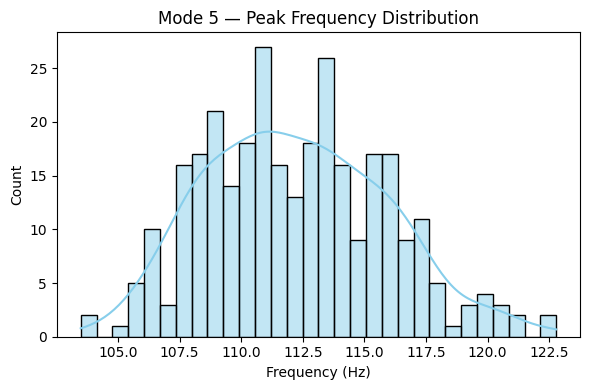

In [28]:
# --- Plot frequency distribution per mode ---
modes = sorted(df_bands['mode'].unique())

for m in modes:
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=df_bands[df_bands['mode'] == m],
        x='peak_freq',
        bins=30,
        kde=True,
        color='skyblue',
        edgecolor='black'
    )
    plt.title(f"Mode {m} — Peak Frequency Distribution")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [41]:
df

,AM0,BM0,ent0,pow0,Cent0,pk0,freq0,skew0,kurt0,Hmob0,...,BM5,ent5,pow5,Cent5,pk5,freq5,skew5,kurt5,Hmob5,Hcomp5
0,1.298168e+16,2.171850e+07,3.695105,0.000244,1.225309,0.250691,0.244141,-0.400528,1.129028,0.044575,...,2.516093e+09,6.766523,0.000019,112.467942,0.013525,113.769531,0.000268,0.063568,1.967847,1.000569


In [47]:
all_feature_rows = []
all_labels = []

for ch_idx in range(n_channels_to_process):  # all channels
    name = f"meg_channel_{ch_idx}"
    features_path = os.path.join(output_base, name, method, "features", f"{name}_features.csv")
    
    if not os.path.exists(features_path):
        continue
    
    df = pd.read_csv(features_path)
    for mode_idx in range(6):
        feature_cols = [f"{f}{mode_idx}" for f in ["AM", "BM", "ent", "Cent", "Pfreq", "Ppeak", "skew", "kurt", "Hmob", "Hcomp"]]
        row = df[feature_cols].iloc[0].values
        all_feature_rows.append(row)
        all_labels.append((ch_idx, mode_idx))

features_df = pd.DataFrame(all_feature_rows, columns=["AM", "BM", "ent", "Cent", "Pfreq", "Ppeak", "skew", "kurt", "Hmob", "Hcomp"])
features_df["channel"] = [lbl[0] for lbl in all_labels]
features_df["mode"] = [lbl[1] for lbl in all_labels]


#["ent", "Pfreq", "Ppeak", "skew", "kurt", "Hcomp"]
#["AM", "BM", "ent", "Cent", "Pfreq", "Ppeak", "skew", "kurt", "Hmob", "Hcomp"]

In [37]:
features_df

,AM,BM,ent,Cent,Pfreq,Ppeak,skew,kurt,Hmob,Hcomp,channel,mode
0,8.119955e-14,9.196464e-22,3.759651,0.923796,3.675340e-24,0.118182,-0.400528,1.129028,0.044575,10.319955,0,0
1,6.528492e-14,5.711572e-22,3.833272,11.170479,2.281383e-24,10.975758,-0.004480,0.405132,0.290161,1.223980,0,1
2,3.494496e-14,1.594276e-22,3.876098,31.564440,6.344653e-25,29.739394,-0.002397,0.127830,0.783781,1.070851,0,2
3,2.997825e-14,1.166487e-22,3.349615,59.525454,4.633496e-25,55.318182,0.000016,0.100989,1.361271,1.018657,0,3
4,3.178909e-14,1.304211e-22,3.774767,86.186357,5.184391e-25,87.963636,-0.000036,-0.053914,1.762013,1.004322,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1831,1.186779e-12,1.953342e-19,3.540699,11.278538,7.795479e-22,11.069697,0.061165,0.959115,0.293747,1.229574,305,1
1832,6.545652e-13,5.548997e-20,3.877339,31.968410,2.201712e-22,35.006061,0.000996,0.006907,0.792935,1.068996,305,2
1833,5.832399e-13,4.427707e-20,3.886385,58.855349,1.753196e-22,55.915152,0.000816,0.028034,1.348999,1.018109,305,3
1834,5.730931e-13,4.250325e-20,3.861664,85.340879,1.682243e-22,87.300000,-0.023265,0.004420,1.751640,1.004855,305,4


<Axes: >

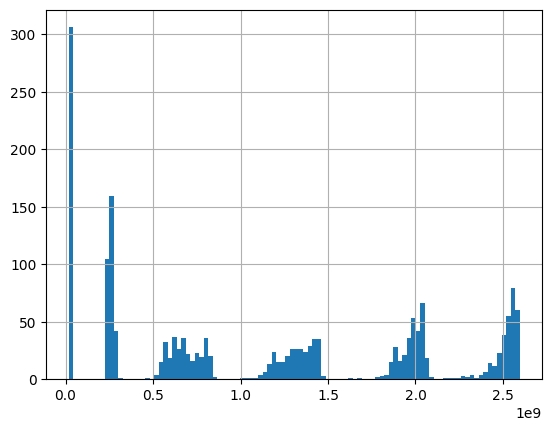

In [48]:
features_df.BM.hist(bins=100)

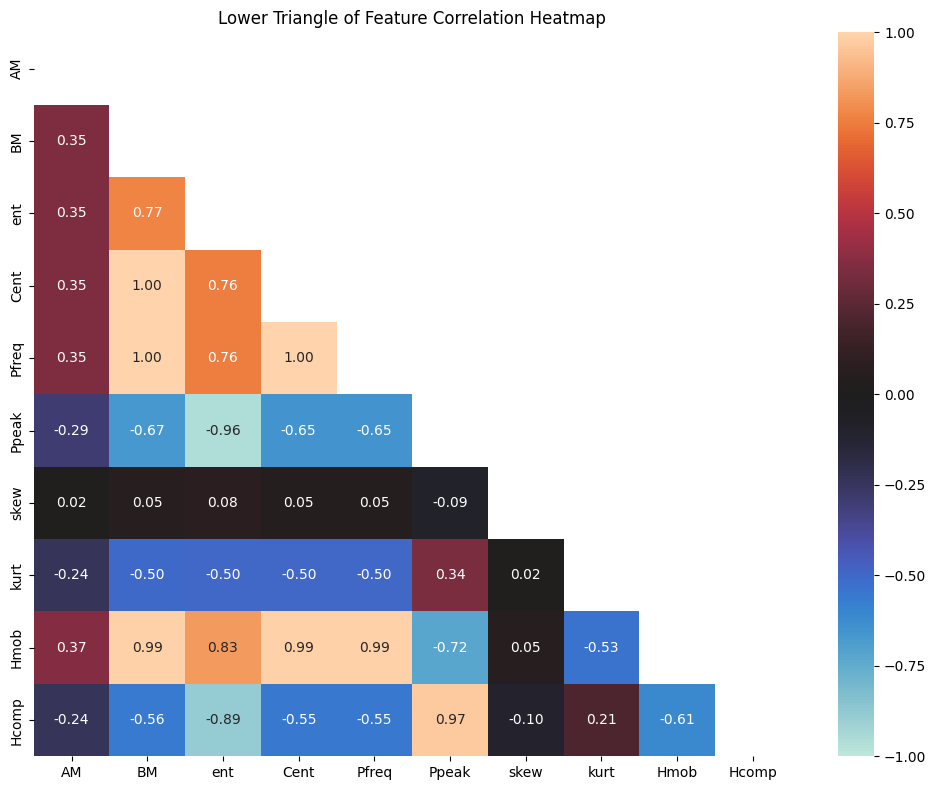

In [ ]:
# Compute correlation matrix
corr = features_df[["AM", "BM", "ent", "Cent", "Pfreq", "Ppeak", "skew", "kurt", "Hmob", "Hcomp"]].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,           # ✅ hide upper triangle
    annot=True,          # ✅ show numbers
    fmt=".2f",           # 2 decimal points
    cmap="icefire",
    vmin=-1, vmax=1
)
plt.title("Lower Triangle of Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

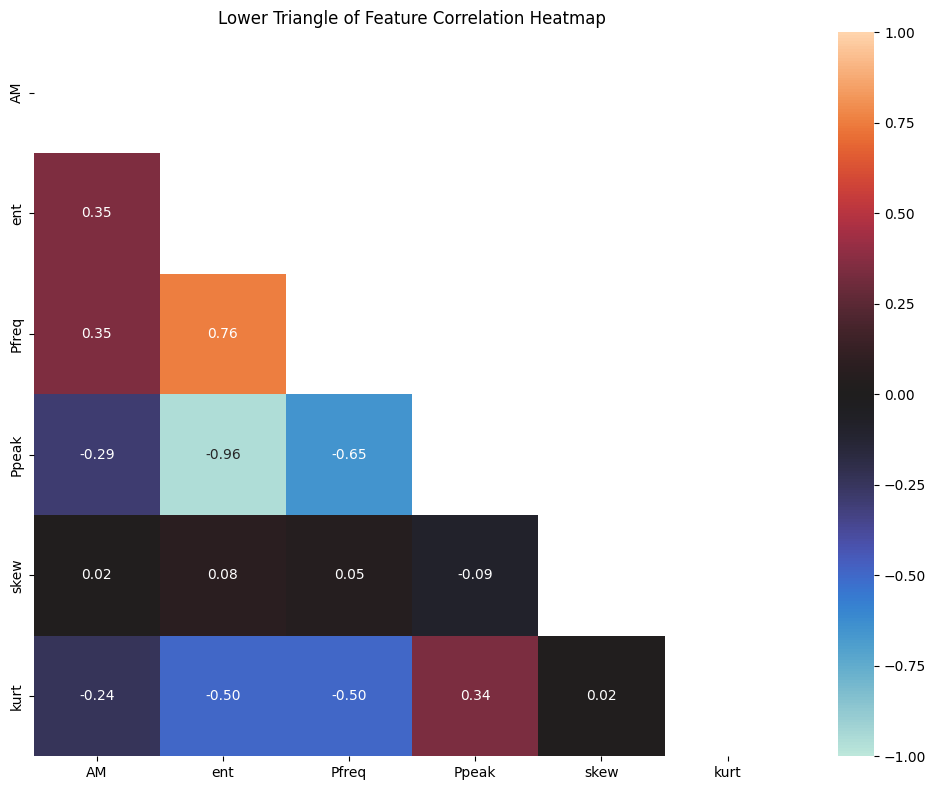

In [ ]:
# Compute correlation matrix
corr = features_df[["AM", "ent", "Pfreq", "Ppeak", "skew", "kurt"]].corr()


# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,           # ✅ hide upper triangle
    annot=True,          # ✅ show numbers
    fmt=".2f",           # 2 decimal points
    cmap="icefire",
    vmin=-1, vmax=1
)
plt.title("Lower Triangle of Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [50]:
# Ensure same types
features_df["channel"] = features_df["channel"].astype(str)
df_bands["channel"] = df_bands["channel"].astype(str)

features_df["mode"] = features_df["mode"].astype(int)
df_bands["mode"] = df_bands["mode"].astype(int)

# Merge
features_df["channel"] = features_df["channel"].apply(lambda x: f"meg_channel_{x}")
merged_df = pd.merge(features_df, df_bands, on=["channel", "mode"])
print("merged_df shape:", merged_df.shape)  

merged_df shape: (1836, 14)


In [148]:
X = merged_df.drop(columns=["channel", "mode","band"])
X_scaled = StandardScaler().fit_transform(X)

In [149]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)
merged_df["PC1"] = proj[:, 0]
merged_df["PC2"] = proj[:, 1]

In [150]:
k = 4  # try also 4, 5, 7
kmeans = KMeans(n_clusters=k, random_state=42,init='k-means++',n_init=50 )
merged_df["cluster"] = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=1.2, min_samples=80)  # Use your elbow and same min_samples as the k
merged_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

In [ ]:
# from yellowbrick.cluster import KElbowVisualizer

# # Optional: scale your data first
# feature_cols = ["AM", "BM", "ent", "Cent", "Pfreq", "Ppeak", "skew", "kurt", "Hmob", "Hcomp"]
# X = features_df[feature_cols].dropna()
# X_scaled = StandardScaler().fit_transform(X)

# # Instantiate the KMeans model (no need to specify n_clusters here)
# model = KMeans(init='k-means++', random_state=42)

# # Use the elbow visualizer
# visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)

# # Fit and show
# visualizer.fit(X_scaled)
# visualizer.show()


ModuleNotFoundError: No module named 'yellowbrick'

In [151]:
contingency_kmeans = pd.crosstab(merged_df['cluster'], merged_df['band'])
contingency_dbscan = pd.crosstab(merged_df['dbscan_cluster'], merged_df['band'])

In [152]:
contingency_kmeans

band,Alpha,Beta,Gamma,High Gamma,NotClassified
cluster,,,,,
0,306,17,0,0,28
1,0,0,308,306,0
2,0,186,407,0,0
3,0,0,0,0,278


In [146]:
contingency_dbscan

band,Alpha,Beta,Gamma,High Gamma,NotClassified
dbscan_cluster,,,,,
-1,18,0,0,1,78
0,288,17,0,0,0
1,0,186,715,305,0
2,0,0,0,0,228


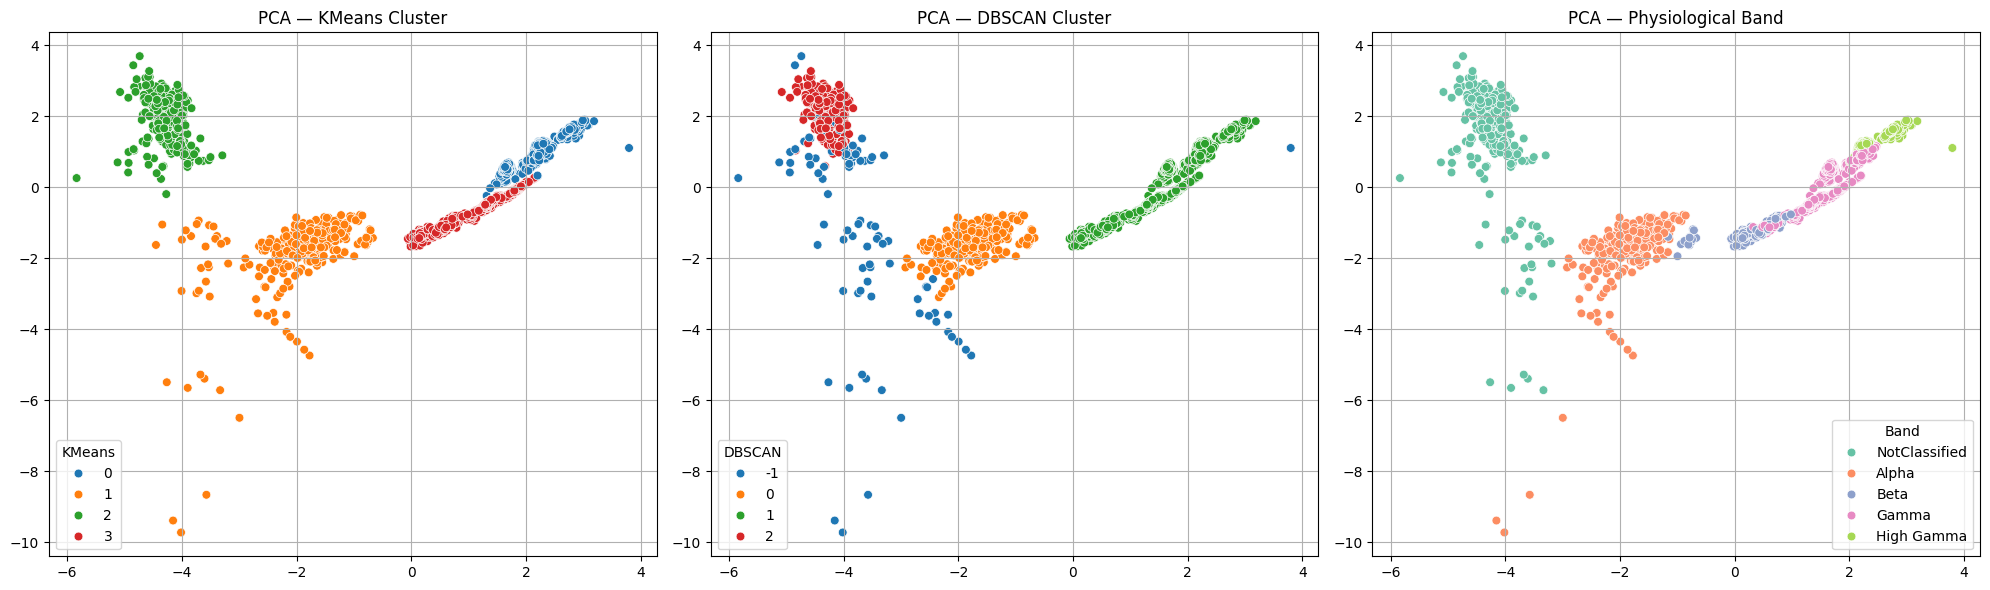

In [147]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 1️⃣ KMeans clusters
sns.scatterplot(ax=axs[0], x=proj[:, 0], y=proj[:, 1],
                hue=merged_df["cluster"], palette="tab10", s=40)
axs[0].set_title("PCA — KMeans Cluster")
axs[0].grid(True)
axs[0].legend(title="KMeans", loc="best")

# 2️⃣ DBSCAN clusters
sns.scatterplot(ax=axs[1], x=proj[:, 0], y=proj[:, 1],
                hue=merged_df["dbscan_cluster"], palette="tab10", s=40)
axs[1].set_title("PCA — DBSCAN Cluster")
axs[1].grid(True)
axs[1].legend(title="DBSCAN", loc="best")

# 3️⃣ Physiological Bands
sns.scatterplot(ax=axs[2], x=proj[:, 0], y=proj[:, 1],
                hue=merged_df["band"], palette="Set2", s=40)
axs[2].set_title("PCA — Physiological Band")
axs[2].grid(True)
axs[2].legend(title="Band", loc="best")

plt.tight_layout()
plt.show()


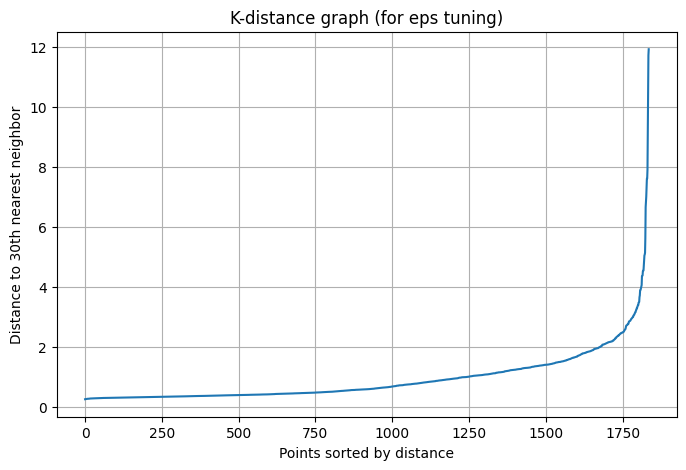

In [454]:
k = 30  # same as min_samples
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])  # Distance to k-th neighbor

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("K-distance graph (for eps tuning)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.grid(True)
plt.show()


In [20]:
n_channels_to_process = 10  # First 10 magnetometers

signal_list = [data_matrix[ch_idx, :] for ch_idx in range(n_channels_to_process)]
signal_names = [f"meg_channel_{ch_idx}" for ch_idx in range(n_channels_to_process)]

# Select only first 5 signals for plotting
signal_list_subset = signal_list[:5]
signal_names_subset = signal_names[:5]


report_df = summarize_decomposition_results(
    signal_list=signal_list_subset,
    signal_names=signal_names_subset,
    sfreq=250,  # sampling frequency of your data
    base_dir="../results/real",
    n_modes_to_use=None
)

report_df.to_csv("../results/real/report_real_meg.csv", index=False)


In [21]:
report_df

,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First N Modes),Number of Extracted Modes,AM,BM,Entropy,Centroid,Power Spectrum Sum,Skewness,Kurtosis,Hjorth Mobility,Hjorth Complexity
0,VMD,meg_channel_0,0,0.118182,9.037207e-08,9.037207e-08,6,8.119923e-14,9.196391e-22,3.759615,0.923740,3.675311e-24,-0.400527,1.129025,0.044566,10.324827
1,VMD,meg_channel_0,1,10.975758,9.037207e-08,9.037207e-08,6,6.523218e-14,5.702024e-22,3.833370,11.168361,2.280810e-24,-0.004510,0.405245,0.290093,1.223868
2,VMD,meg_channel_0,2,29.739394,9.037207e-08,9.037207e-08,6,3.486562e-14,1.586413e-22,3.876078,31.543735,6.345650e-25,-0.002396,0.128134,0.783301,1.070891
3,VMD,meg_channel_0,3,55.318182,9.037207e-08,9.037207e-08,6,2.987215e-14,1.158311e-22,3.349127,59.500659,4.633244e-25,0.000017,0.101366,1.360822,1.018682
4,VMD,meg_channel_0,4,87.963636,9.037207e-08,9.037207e-08,6,3.169919e-14,1.296595e-22,3.774796,86.170819,5.186382e-25,-0.000023,-0.053846,1.761828,1.004329
5,VMD,meg_channel_0,5,111.066667,9.037207e-08,9.037207e-08,6,2.974080e-14,1.144852e-22,3.385360,112.463889,4.579407e-25,0.000268,0.063651,1.967820,1.000569
6,VMD,meg_channel_1,0,0.290909,2.642968e-06,2.642968e-06,6,1.866706e-12,4.672628e-19,3.912879,0.752011,1.869014e-21,0.577562,0.692957,0.038850,11.276813
7,VMD,meg_channel_1,1,10.036364,2.642968e-06,2.642968e-06,6,9.212554e-13,1.141570e-19,3.724710,11.891800,4.566280e-22,-0.061762,0.460571,0.314254,1.292449
8,VMD,meg_channel_1,2,37.509091,2.642968e-06,2.642968e-06,6,6.351939e-13,5.237477e-20,3.871697,34.534223,2.094991e-22,0.000954,0.048568,0.851067,1.060715
9,VMD,meg_channel_1,3,60.566667,2.642968e-06,2.642968e-06,6,5.922288e-13,4.531449e-20,3.786731,60.908737,1.812580e-22,0.000706,-0.020836,1.386056,1.015921


## 4. Apply the MFA:

Processing signal: meg_channel_0


<Figure size 800x400 with 0 Axes>

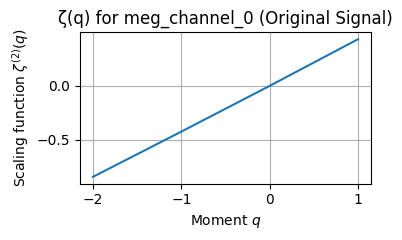

<Figure size 800x400 with 0 Axes>

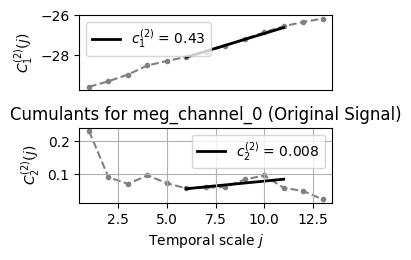

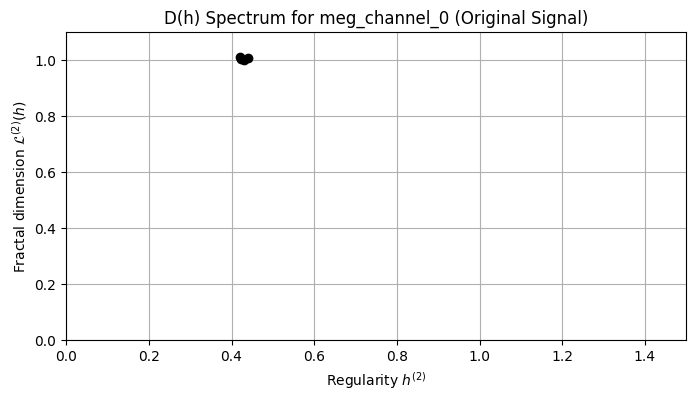

Processing signal: meg_channel_1


<Figure size 800x400 with 0 Axes>

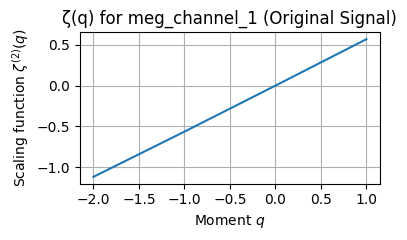

<Figure size 800x400 with 0 Axes>

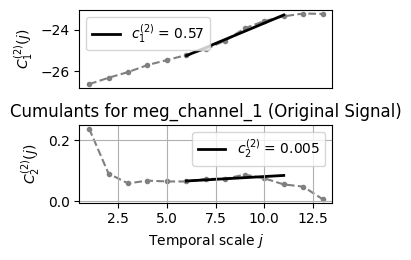

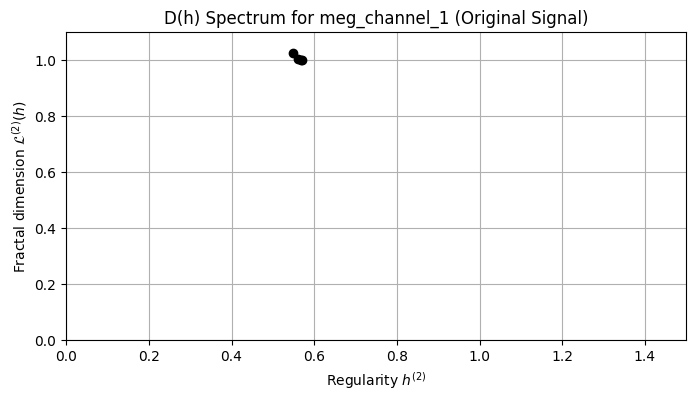

Processing signal: meg_channel_2


<Figure size 800x400 with 0 Axes>

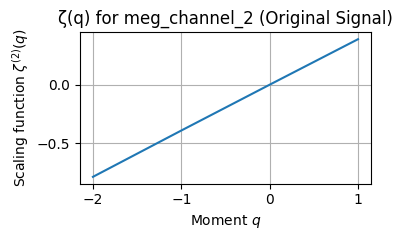

<Figure size 800x400 with 0 Axes>

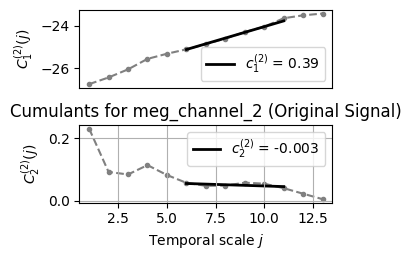

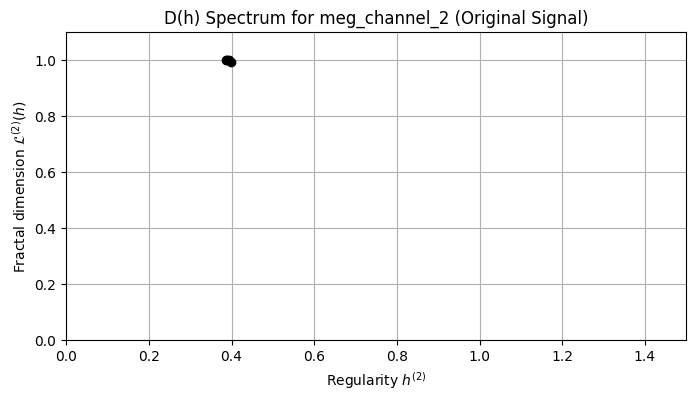

Processing signal: meg_channel_3


<Figure size 800x400 with 0 Axes>

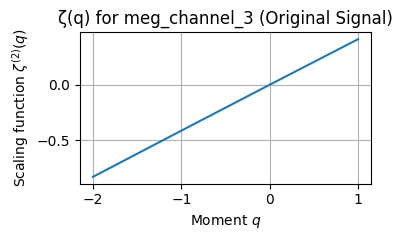

<Figure size 800x400 with 0 Axes>

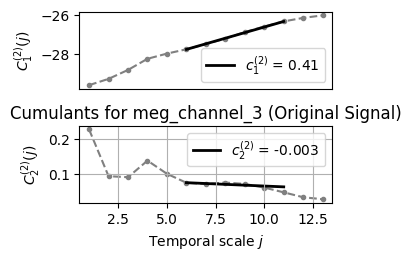

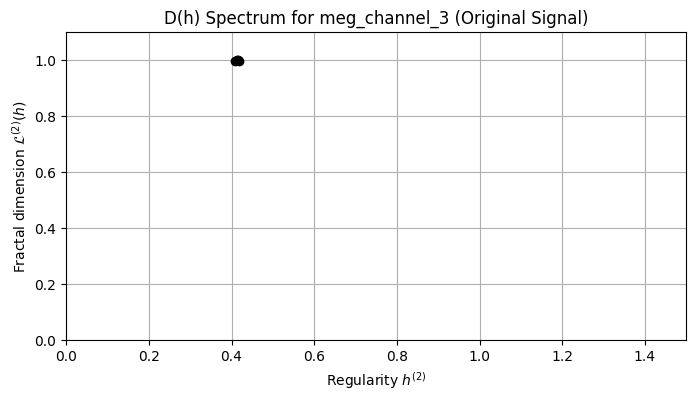

Processing signal: meg_channel_4


<Figure size 800x400 with 0 Axes>

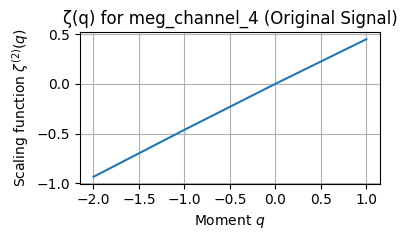

<Figure size 800x400 with 0 Axes>

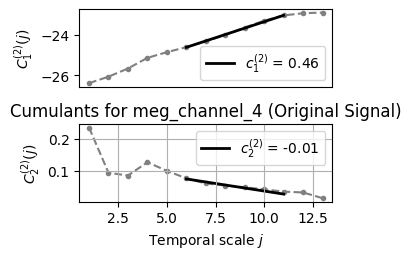

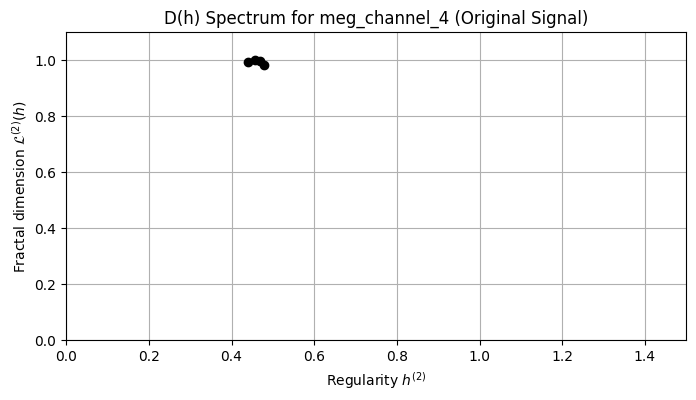

Processing signal: meg_channel_5


<Figure size 800x400 with 0 Axes>

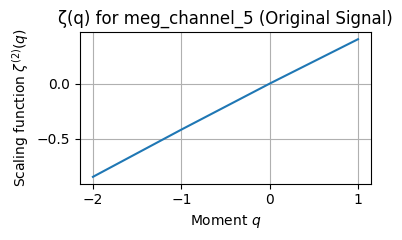

<Figure size 800x400 with 0 Axes>

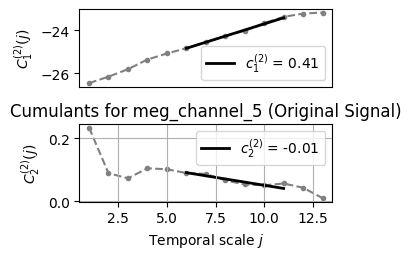

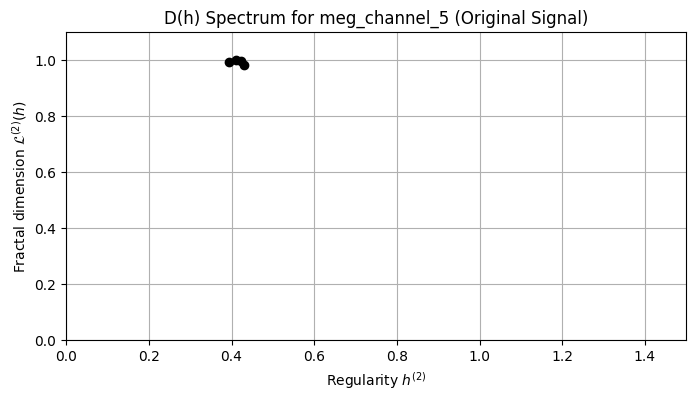

Processing signal: meg_channel_6


<Figure size 800x400 with 0 Axes>

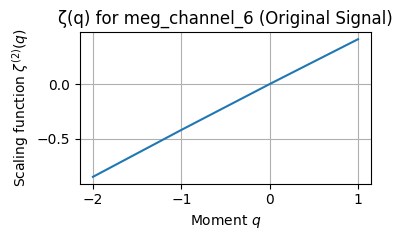

<Figure size 800x400 with 0 Axes>

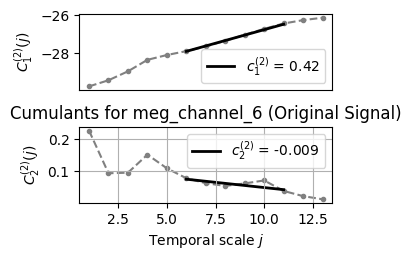

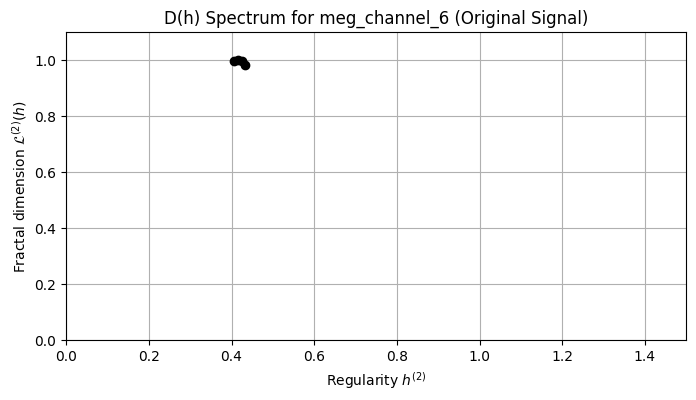

Processing signal: meg_channel_7


<Figure size 800x400 with 0 Axes>

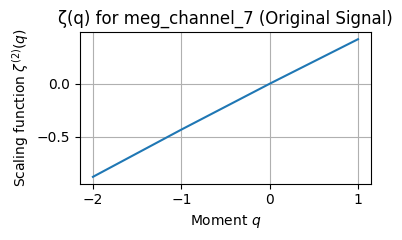

<Figure size 800x400 with 0 Axes>

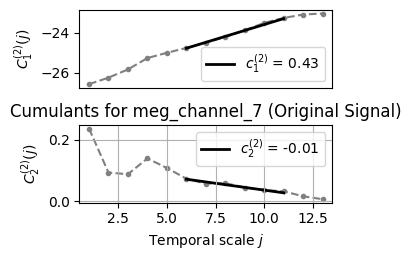

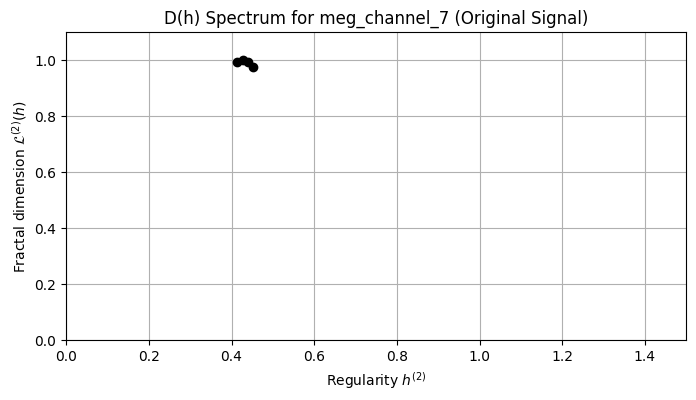

Processing signal: meg_channel_8


<Figure size 800x400 with 0 Axes>

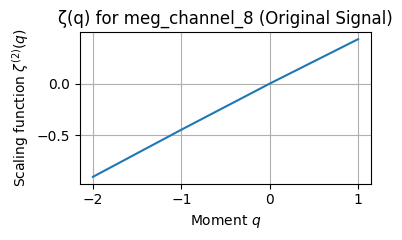

<Figure size 800x400 with 0 Axes>

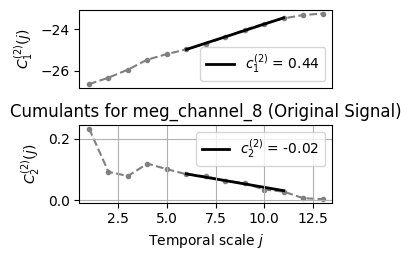

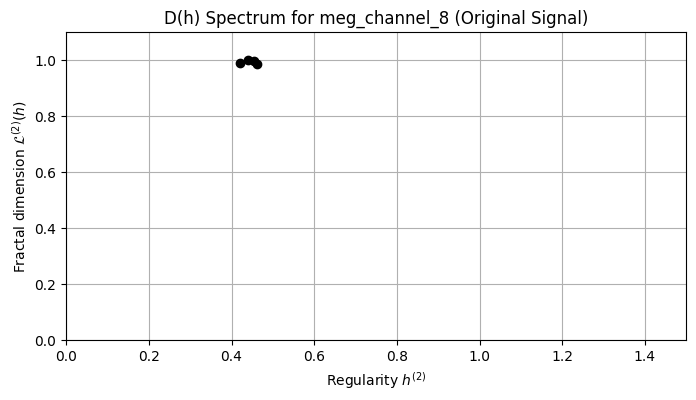

Processing signal: meg_channel_9


<Figure size 800x400 with 0 Axes>

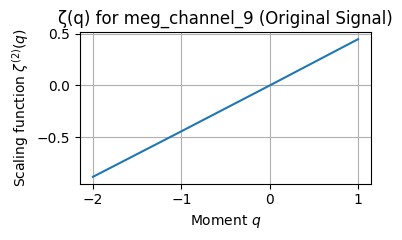

<Figure size 800x400 with 0 Axes>

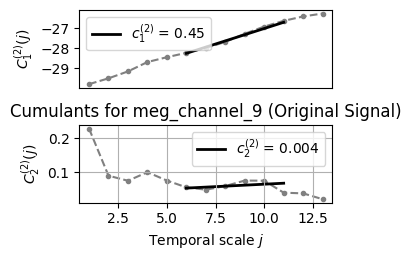

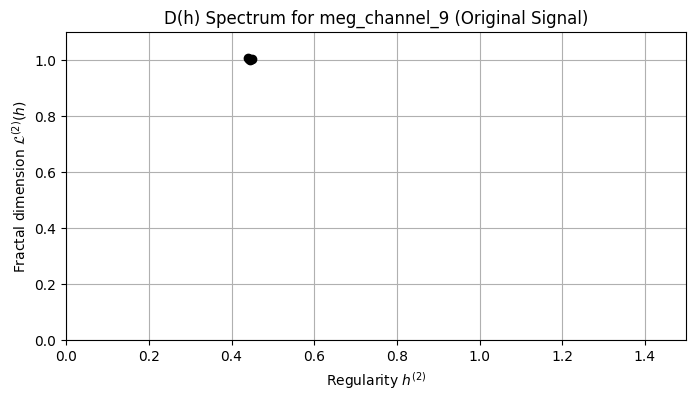

In [ ]:
scaling_ranges = [(6, 11)]
q_vals = np.arange(-2, 2)
summary_records = []
methods = ["VMD"]


signal_list = [data_matrix[ch_idx, :] for ch_idx in range(n_channels_to_process)]
signal_names = [f"meg_channel_{ch_idx}" for ch_idx in range(n_channels_to_process)]


for signal, name in zip(signal_list, signal_names):
    print(f"Processing signal: {name}")

    # MFA on original signal
    pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
    plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")
    summary_records.append({
        "Signal": name,
        "Mode": "Original",
        "Log-cumulant 1": pwt_signal.cumulants.values[0],
        "Log-cumulant 2": pwt_signal.cumulants.values[1]

    })

    for method in methods:
        modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(modes_path):
            print(f"Modes not found for {name} / {method} at {modes_path}")
            continue

        modes = np.load(modes_path)
        print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

        for idx, mode in enumerate(modes):
            pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
            #plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
            summary_records.append({
                "Signal": name,
                "Mode": f"{method} Mode {idx}",
                "Log-cumulant 1": pwt_mode.cumulants.values[0],
                "Log-cumulant 2": pwt_mode.cumulants.values[1]
            })

summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [103]:
summary_df['C1_flat'] = summary_df['Log-cumulant 1'].apply(lambda arr: arr.flatten())
summary_df['C2_flat'] = summary_df['Log-cumulant 2'].apply(lambda arr: arr.flatten())

# Check the new columns
summary_df

,Signal,Mode,Log-cumulant 1,Log-cumulant 2,C1_flat,C2_flat
0,meg_channel_0,Original,"[[[-29.602716263113127]], [[-29.31714420502243...","[[[0.23107844912306064]], [[0.0905390461256274...","[-29.602716263113127, -29.317144205022434, -28...","[0.23107844912306064, 0.09053904612562746, 0.0..."
1,meg_channel_1,Original,"[[[-26.632769042210377]], [[-26.32331016613688...","[[[0.2380243922268619]], [[0.09043441583366985...","[-26.632769042210377, -26.32331016613688, -26....","[0.2380243922268619, 0.09043441583366985, 0.05..."
2,meg_channel_2,Original,"[[[-26.754338789383926]], [[-26.43815269437106...","[[[0.23160975464213607]], [[0.0923626449457515...","[-26.754338789383926, -26.43815269437106, -26....","[0.23160975464213607, 0.09236264494575153, 0.0..."
3,meg_channel_3,Original,"[[[-29.600312825628283]], [[-29.27875497000801...","[[[0.22677845672797048]], [[0.0932712993721907...","[-29.600312825628283, -29.27875497000801, -28....","[0.22677845672797048, 0.0932712993721907, 0.09..."
4,meg_channel_4,Original,"[[[-26.391888594459683]], [[-26.07152800240672...","[[[0.2359528943073883]], [[0.09367060402428251...","[-26.391888594459683, -26.07152800240672, -25....","[0.2359528943073883, 0.09367060402428251, 0.08..."
5,meg_channel_5,Original,"[[[-26.456191512475694]], [[-26.15505306581282...","[[[0.234499896149714]], [[0.08924672360114982]...","[-26.456191512475694, -26.155053065812826, -25...","[0.234499896149714, 0.08924672360114982, 0.072..."
6,meg_channel_6,Original,"[[[-29.778825093468583]], [[-29.45228477191572...","[[[0.2273296678171164]], [[0.09327419226201528...","[-29.778825093468583, -29.45228477191572, -28....","[0.2273296678171164, 0.09327419226201528, 0.09..."
7,meg_channel_7,Original,"[[[-26.57710102709813]], [[-26.25151113276623]...","[[[0.2359377924033197]], [[0.09337817495134004...","[-26.57710102709813, -26.25151113276623, -25.8...","[0.2359377924033197, 0.09337817495134004, 0.08..."
8,meg_channel_8,Original,"[[[-26.64754944140002]], [[-26.334243647534766...","[[[0.23286342051142128]], [[0.0918628190031540...","[-26.64754944140002, -26.334243647534766, -25....","[0.23286342051142128, 0.09186281900315407, 0.0..."
9,meg_channel_9,Original,"[[[-29.787243608197624]], [[-29.49705786568036...","[[[0.2285977707517759]], [[0.08930925421066149...","[-29.787243608197624, -29.497057865680365, -29...","[0.2285977707517759, 0.08930925421066149, 0.07..."
